# CAPSTONE 1 -  MACHINE LEARNING MODELS

This project has 6 quantitative features with a single target containing 2 classes, Normal and Abnormal



0 = Normal of which there are 209 total  
1 = Abnormal of which there are 100 total

30% of the data is stratisfied into a test set due to the unbalanced nature of the set

Resampling is performed with both ADASYN and SMOTE, SMOTE preferred due to the sparse distribution of the minority class, however, not knowing the desired recall balance or bias, ADASYN may be preferred to ensure extreme precision for Normal or Abnormal bias.

Accuracy is measured and compared on the Recall, Precision, and F1, along with plots of ROC and confusion matrix

A summary of the results allows for selection of the best model dependent on prerred recall.

It was a pleasure tuning these machines, feel free to send comments to my email:  mconsultant@protonmail.com


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Machine modeling tools
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE

# Scoring
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix 
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,recall_score

#### Import data variables

In [7]:
X = pd.read_csv('Data/X.csv')         ## 6 Features
Y = np.ravel(pd.read_csv('Data/Y.csv') )      ## Target 'class' 100 abnormal, 209 normal

#### Transform data using Linear Discrimanant Analysis - a Guassian algorithm to improve boundries between colinear features

In [8]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X,Y)

In [9]:
print(lda.explained_variance_ratio_)

[1.]


#### Statisfied train-test split for unbalanced dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, Y, test_size=0.3, 
                                                stratify=Y,random_state = 88)    # 30% test set

#### Functions

In [11]:
# Performs GridSearch of multiple parameters on specified resample algorithM
# Returns the optimal parameter set and their corresponding scores

def gridSearchCV(model, param_grid, X_train, X_Test, y_train, y_test, graph = 1, sampling='none',name='none'):
    
    # Scale the features
    std_scale = StandardScaler()
    X_train_scaled = std_scale.fit_transform(X_train)
    X_test_scaled = std_scale.transform(X_test)
    
    # Fold parameters
    kf = KFold(n_splits=5, shuffle=False)
    
    # create pipeline
    if sampling == 'smote':
        print('SMOTE ANALYSIS')
        resample = SMOTE(random_state=88)
    else:
        print('ADASYN ANALYSIS')
        resample = ADASYN(random_state=88)
    pipeline = Pipeline([('sampling', resample), ('class', model)])
    
    # perform gridsearch, fit, and predict
    grid = GridSearchCV(pipeline, param_grid, scoring = 'f1', cv = kf)
    grid.fit(X_train_scaled, y_train)
    print("Training score: ",clf.score(X_train, y_train))
    predictions = grid.predict(X_test_scaled)
    
    #Graph ROC
    if graph == 1:
        proba_predict = grid.predict_proba(X_test_scaled)
        preds = proba_predict[:,1]
        plot_ROC(grid, preds, X_test_scaled, y_test, graph=graph)
        
    #Return the classification report results
    report = (classification_report(y_test, predictions, output_dict=True))
    print(classification_report(y_test, predictions))
    df = pd.DataFrame(report).transpose() 
    df.insert(0, "Model", [name, name, name, name, name])
    
    #Print the parameters
    print("Best Parameters: ", grid.best_params_)
    
    # Plot confusion matrix
    plot_confusion(y_test,predictions)
    return df

In [12]:
# Plots the ROC of model

def plot_ROC(model, probs, test_features, test_target, graph = 1):
    if graph == 1:
        print("area under curve (auc): ", metrics.roc_auc_score(y_test, probs))
        fpr, tpr, thresholds = roc_curve(test_target, probs)
        plt.plot([0,1],[0,1], linestyle='--')
        plt.plot(fpr, tpr)
        plt.show()

In [13]:
# Plots confusion matrix of model

def plot_confusion(y_test, pred):
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

#### Base Measurement without parameter tuning performed on Logistic Regression

area under curve (auc):  0.9539682539682539


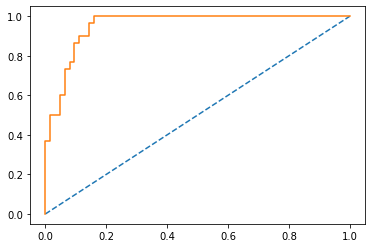

None
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        63
           1       0.81      0.73      0.77        30

    accuracy                           0.86        93
   macro avg       0.85      0.83      0.84        93
weighted avg       0.86      0.86      0.86        93



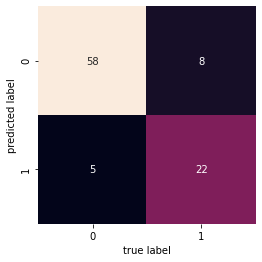

In [14]:
ytrain = np.ravel(y_train) # optimize the shape of y

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, ytrain)
predictions = clf.predict(X_test)
proba = clf.predict_proba(X_test)
probs = proba[:,1]

# Print the accuracy from the testing data.
print(plot_ROC(clf, probs, X_test, y_test))
print(classification_report(y_test, predictions))
plot_confusion(y_test,predictions)

Not bad but a recall that states 20 out of 100 will be incorrectly labeled 

## PARAMETER TUNING

### LOGISTIC REGRESSION

SMOTE ANALYSIS
Training score:  0.8364485981308412
area under curve (auc):  0.9539682539682539


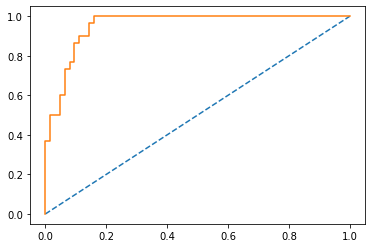

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        63
           1       0.70      1.00      0.82        30

    accuracy                           0.86        93
   macro avg       0.85      0.90      0.85        93
weighted avg       0.90      0.86      0.86        93

Best Parameters:  {'class__C': 0.01, 'class__penalty': 'l2', 'class__solver': 'sag'}


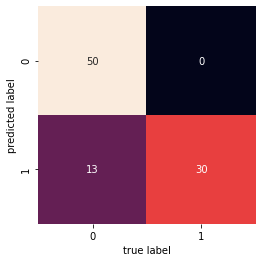

In [15]:
# Test parameter grid for best paramaters
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = [0.001,0.01,0.1, 1, 10]
random_grid = {'class__solver':solvers,'class__penalty':penalty, 'class__C':c_values}

# Perform GridSearch on parameter grid
summary = gridSearchCV(LogisticRegression(random_state=42),random_grid, 
                       X_train, X_test, y_train, y_test,sampling='smote',name='Smote LogReg')

ADASYN ANALYSIS
Training score:  0.8364485981308412
area under curve (auc):  0.9539682539682539


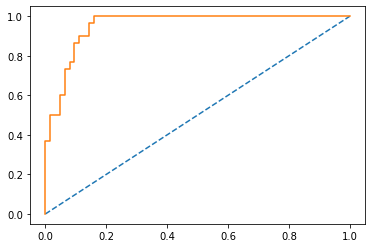

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        63
           1       0.70      1.00      0.82        30

    accuracy                           0.86        93
   macro avg       0.85      0.90      0.85        93
weighted avg       0.90      0.86      0.86        93

Best Parameters:  {'class__C': 1, 'class__penalty': 'l2', 'class__solver': 'newton-cg'}


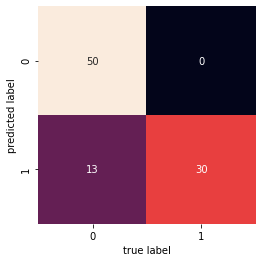

In [16]:
df = gridSearchCV(LogisticRegression(random_state=42), 
             random_grid, X_train, X_test, y_train, y_test, name='Adasyn LR')
summary = summary.append(df)

## GRADIENT BOOSTING CLASSIFIER

SMOTE ANALYSIS
Training score:  0.8364485981308412
area under curve (auc):  0.926984126984127


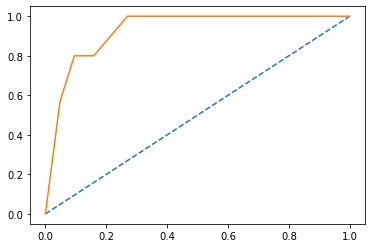

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.80      0.80      0.80        30

    accuracy                           0.87        93
   macro avg       0.85      0.85      0.85        93
weighted avg       0.87      0.87      0.87        93

Best Parameters:  {'class__criterion': 'mae', 'class__learning_rate': 1, 'class__loss': 'exponential', 'class__n_estimators': 11}


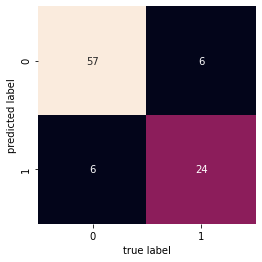

In [17]:
# Test parameter grid for best paramaters
loss = ['deviance', 'exponential']
lr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ne = range(1,100,5)
cr = ['friedman_mse', 'mse', 'mae']
random_grid = {'class__loss':loss,'class__learning_rate':lr,'class__n_estimators':ne, 'class__criterion':cr}

# Perform GridSearch on parameter grid
df = gridSearchCV(GradientBoostingClassifier(random_state=42), random_grid, 
             X_train, X_test, y_train, y_test, sampling='smote', name='Smote GB')
summary = summary.append(df)

In [18]:
# Test parameter grid for best paramaters
loss = ['deviance', 'exponential']
lr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ne = range(1,100,5)
cr = ['friedman_mse', 'mse', 'mae']
random_grid = {'class__loss':loss,'class__learning_rate':lr,'class__n_estimators':ne, 'class__criterion':cr}
df = gridSearchCV(GradientBoostingClassifier(random_state=42), random_grid, 
             X_train, X_test, y_train, y_test, name='Adasyn GB')
summary = summary.append(df)

ADASYN ANALYSIS


KeyboardInterrupt: 

## SUPPORT VECTOR MACHINE

In [ ]:
param_grid = {'class__C': [0.1, 1, 10, 100, 1000],  
              'class__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'class__kernel': ['rbf']}  

df = gridSearchCV(SVC(random_state=42), param_grid, 
             X_train, X_test, y_train, y_test, graph=2, sampling='smote',name='Smote SVM')
summary = summary.append(df)

In [ ]:
df = gridSearchCV(SVC(random_state=42), param_grid, 
                  X_train, X_test, y_train, y_test, graph=2,name='Adasyn SVM')
summary = summary.append(df)

## RANDOM FOREST CLASSIFIER

In [ ]:
param_grid = {'class__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 
              'class__max_depth': range(1,32,1),
              'class__min_samples_leaf': [1, 2, 3, 4, 5], 
              'class__criterion': ['gini', 'entropy']}  

df = gridSearchCV(RandomForestClassifier(random_state=42), param_grid, 
             X_train, X_test, y_train, y_test, sampling='smote',name='Smote RF')
summary = summary.append(df)

In [ ]:
df = gridSearchCV(RandomForestClassifier(random_state=42), param_grid, 
                  X_train, X_test, y_train, y_test, name='Adasyn RF')
summary = summary.append(df)

## KNEIGHBORS CLASSIFIER

#### Base Measure without tuning

In [ ]:
param_grid = {'class__algorithm': ['auto'], 
              'class__leaf_size': [1,5,10,15,20,25,30], 
             'class__n_neighbors':[1,2,3,4,5,6,7,8],
             'class__p':[1,2],
             'class__weights':['uniform','distance']}  

df = gridSearchCV(KNeighborsClassifier(), param_grid, 
                  X_train, X_test, y_train, y_test, sampling='smote', name='Smote KNN')
summary = summary.append(df)

In [ ]:
df = gridSearchCV(KNeighborsClassifier(), param_grid, 
                  X_train, X_test, y_train, y_test, name = 'Adasyn KNN')

### Gaussian Naive Bayes

In [ ]:
param_grid = {'class__var_smoothing':[1e-1,1e-9,1e-19,1e-29]}
df = gridSearchCV(GaussianNB(priors=None, ), param_grid, 
                  X_train, X_test, y_train, y_test, sampling='smote', name='Smote NB')
summary = summary.append(df)

In [ ]:
df = gridSearchCV(GaussianNB(priors=None, ), param_grid, 
                  X_train, X_test, y_train, y_test, name='Adasyn NB')
summary = summary.append(df)

In [ ]:
print(summary)